In [1]:
## set those accordingly
datadir = '../../Datasets/'

abcd_path = '/c/src/DS_8014/ABCDGraphGenerator.jl/utils/'

In [2]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from collections import Counter
import os
import umap
import pickle
import partition_igraph
import subprocess
from sklearn.metrics import adjusted_mutual_info_score as AMI

## we used those for the book, but you can change to other colors
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']

c:\src\DS_8014\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
z = ig.Graph.Famous('zachary')
z.vs['size'] = 12
z.vs['name'] = [str(i) for i in range(z.vcount())]
z.vs['label'] = [str(i) for i in range(z.vcount())]
z.vs['label_size'] = 8
z.es['color'] = cls_edges
z.vs['comm'] = [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]
z.vs['color'] = [cls[i] for i in z.vs['comm']]
#ig.plot(z, 'zachary_gt.eps', bbox=(0,0,300,200))
ig.plot(z, bbox=(0,0,350,250))

## compute internal degrees
in_deg_0 = z.subgraph_edges([e for e in z.es if z.vs['comm'][e.tuple[0]]==0 and z.vs['comm'][e.tuple[1]]==0],
                            delete_vertices=False).degree()
in_deg_1 = z.subgraph_edges([e for e in z.es if z.vs['comm'][e.tuple[0]]==1 and z.vs['comm'][e.tuple[1]]==1],
                            delete_vertices=False).degree()

## compute z (normalized within-module degree)
z.vs['in_deg'] = [in_deg_0[i] + in_deg_1[i] for i in range(z.vcount())]
mu = [np.mean([x for x in in_deg_0 if x>0]),np.mean([x for x in in_deg_1 if x>0])]
sig = [np.std([x for x in in_deg_0 if x>0],ddof=1),np.std([x for x in in_deg_1 if x>0],ddof=1)]
z.vs['z'] = [(v['in_deg']-mu[v['comm']])/sig[v['comm']] for v in z.vs]

## computing p (participation coefficient)
z.vs['deg'] = z.degree()
z.vs['out_deg'] = [v['deg'] - v['in_deg'] for v in z.vs]
z.vs['p'] = [1-(v['in_deg']/v['deg'])**2-(v['out_deg']/v['deg'])**2 for v in z.vs]
D = pd.DataFrame(np.array([z.vs['z'],z.vs['p']]).transpose(),columns=['z','p']).sort_values(by='z',ascending=False)
D.head()

,z,p
33,3.133291,0.207612
0,3.104691,0.218750
32,2.005306,0.152778
1,1.218296,0.197531
3,0.589498,0.000000


# Q1

In [6]:
##ECG, Louvain, Infomap, Label Propagation, Girvan-Newman, and CNM
ecg = z.community_ecg()
louvain = z.community_multilevel()
info_map = z.community_infomap()
lab_prop = z.community_label_propagation()
gn = z.community_edge_betweenness()
cnm = z.community_fastgreedy()

## show result with 2 clusters -- 
z.vs['gn'] = gn.as_clustering(n=2).membership
z.vs['cnm'] = cnm.as_clustering(n=2).membership

print('ECG AMI:',AMI(z.vs['comm'],ecg.membership))  
print('Louvain AMI::',AMI(z.vs['comm'],louvain.membership)) 
print('Info_map AMI:',AMI(z.vs['comm'],info_map.membership)) 
print('Label Prop AMI:',AMI(z.vs['comm'], lab_prop.membership))  
print('GN AMI (n=2):',AMI(z.vs['comm'],z.vs['gn']))
print('CNM AMI (n=2):',AMI(z.vs['comm'],z.vs['cnm']))  
print('GN AMI:',AMI(z.vs['comm'],gn.as_clustering().membership))
print('CNM AMI:',AMI(z.vs['comm'],cnm.as_clustering().membership))

ECG AMI: 0.4784978773634959
Louvain AMI:: 0.5653497612707892
Info_map AMI: 0.687422347904921
Label Prop AMI: 0.687422347904921
GN AMI (n=2): 0.8327564079186137
CNM AMI (n=2): 0.8334659946350966
GN AMI: 0.5499173029289166
CNM AMI: 0.6807645098886008


# Q2 Run various clustering algorithms (ECG, Louvain, Infomap, Label Propagation; Girvan-Newman and CNM; note that CNM might be too slow but give it a try anyways) on the GitHub ml graph. Which algorithms produce similar results? In order to answer this question, for each pair of algorithms, find the AMI score between the two results.

In [3]:
D_gh = pd.read_csv(datadir + 'GitHubDevelopers/musae_git_edges.csv')
tuples = [tuple(x) for x in D_gh.values]
gh = ig.Graph.TupleList(tuples, directed=False)

X = pd.read_csv(datadir+'GitHubDevelopers/musae_git_target.csv')

#Map node names in edgelist to indices in the graph
idx = [int(i) for i in gh.vs['name']]

lbl = ['web','ml']
gh.vs['lbl'] = [lbl[i] for i in list(X['ml_target'])]

gh_ml = gh.subgraph([v for v in gh.vs() if v['lbl'] == 'ml'])
gh_web = gh.subgraph([v for v in gh.vs() if v['lbl'] == 'web'])
print('GitHub nodes:',gh.vcount(),'; ml developers:',gh_ml.vcount(),'; web developers:',gh_web.vcount())

GitHub nodes: 37700 ; ml developers: 9739 ; web developers: 27961


In [4]:
ecg = gh_ml.community_ecg()
louvain = gh_ml.community_multilevel()
info_map = gh_ml.community_infomap()
lab_prop = gh_ml.community_label_propagation()
cnm = gh_ml.community_fastgreedy()

In [9]:
#takes about two hours then crash
#gn = gh_ml.community_edge_betweenness()


In [5]:
community_result_dict = {
    "ecg": ecg,
    "louvain": louvain,
    "info_map": info_map,
    "lab_prop": lab_prop,
    "cnm": cnm
    #"gn": gn,
    
}

In [7]:
def print_ami_comparison(input_membership, name, community_dict):
    print(f"COMPARISONS FOR {name}")
    print(f'{name} vs ECG AMI:',AMI(input_membership, community_dict["ecg"].membership))  
    print(f'{name} vs Louvain AMI:',AMI(input_membership, community_dict["louvain"].membership)) 
    print(f'{name} vs Info_map AMI:',AMI(input_membership, community_dict["info_map"].membership)) 
    print(f'{name} vs Label Prop AMI:',AMI(input_membership, community_dict["lab_prop"].membership))  
    #print(f'{name} vs GN AMI:',AMI(input_membership,community_dict["gn"].membership))
    print(f'{name} vs CNM AMI:',AMI(input_membership,community_dict["cnm"].as_clustering().membership))
    print("\n")

print_ami_comparison(cnm.as_clustering().membership, "CNM", community_result_dict)
print_ami_comparison(ecg.membership, "ECG", community_result_dict)
print_ami_comparison(louvain.membership, "Louvain", community_result_dict)
print_ami_comparison(info_map.membership, "Info Map", community_result_dict)
print_ami_comparison(lab_prop.membership, "Label Prop", community_result_dict)
#print_ami_comparison(gn.membership, "GN", community_result_dict)


COMPARISONS FOR CNM
CNM vs ECG AMI: 0.5203547488464255
CNM vs Louvain AMI: 0.6175719100274567
CNM vs Info_map AMI: 0.4544759978952388
CNM vs Label Prop AMI: 0.6850320979448454
CNM vs CNM AMI: 1.0


COMPARISONS FOR ECG
ECG vs ECG AMI: 1.0
ECG vs Louvain AMI: 0.6013590463320131
ECG vs Info_map AMI: 0.6088437931270099
ECG vs Label Prop AMI: 0.4959272018772716
ECG vs CNM AMI: 0.5203547488180151


COMPARISONS FOR Louvain
Louvain vs ECG AMI: 0.6013590463490521
Louvain vs Louvain AMI: 1.0
Louvain vs Info_map AMI: 0.5114945302159781
Louvain vs Label Prop AMI: 0.6270863954516563
Louvain vs CNM AMI: 0.6175719100232777


COMPARISONS FOR Info Map
Info Map vs ECG AMI: 0.6088437931208596
Info Map vs Louvain AMI: 0.5114945301441123
Info Map vs Info_map AMI: 1.0
Info Map vs Label Prop AMI: 0.3024381755145819
Info Map vs CNM AMI: 0.4544759978026166


COMPARISONS FOR Label Prop
Label Prop vs ECG AMI: 0.49592720188880174
Label Prop vs Louvain AMI: 0.6270863954410633
Label Prop vs Info_map AMI: 0.30243817

#Q5 Take the ABCD graph we used to test quality measures (see Figure 5.9). Check node roles. Compute how many nodes we have in each family (recall that there are 4 families of non-hubs and 3 families of hubs). Plot the (z(v); p(v)) scores for all nodes as we did in Figure 5.3 for the karate club graph.

n = 1;000, 
the degree distribution exponent gamma = 2.5 
with degrees in the range [5; 50], 
the community size exponent tau = 1:5 within the range [75; 150]
the mixing parameter = 0.1.

In [8]:
def generate_abcd(n, gamma, tau, min_degree, max_degree, min_community, max_community, mixing_parameter):
    abcd_path = "C:/src/DS_8014/ABCDGraphGenerator.jl/utils/"
    output_path = "C:/src/DS_8014/GraphMiningNotebooks/Python_Notebooks/Assignments/"
    cmd = f'julia {abcd_path}deg_sampler.jl {output_path}deg_{n}.dat {gamma} {min_degree} {max_degree} {n} {n}'
    #print(cmd)
    os.system(cmd)
    cmd = f'julia {abcd_path}com_sampler.jl {output_path}cs_{n}.dat {tau} {min_community} {max_community} ' + str(n) + ' ' + str(n)
    os.system(cmd)
    #print(cmd)
    xi = mixing_parameter
    cmd = f'julia {abcd_path}graph_sampler.jl {output_path}net_{n}.dat {output_path}comm_{n}.dat {output_path}deg_{n}.dat {output_path}cs_{n}.dat xi {xi} false false'
    os.system(cmd)
    #print(cmd)
    g = ig.Graph.Read_Ncol(f'{output_path}net_{n}.dat',directed=False)
    c = np.loadtxt(f'{output_path}comm_{n}.dat',dtype='uint16',usecols=(1))
    ## ground-truth communities
    gt = [c[int(x['name'])-1]-1 for x in g.vs]
    print('number of communities:',np.max(gt)+1)
    g.vs["comm"] = gt
    return g

In [9]:
n=1000
g = generate_abcd(n=n, gamma=2.5, tau=1.5, min_degree=5, max_degree=50, min_community=75, max_community=150, mixing_parameter=0.1)
num_communities = np.max(g.vs["comm"])+1
print('number of communities:',num_communities)

number of communities: 10
number of communities: 10


# Number of Nodes in Each Family

In [10]:
community_count = dict()
for i in range(num_communities):
    community_count[i] = []

for v in g.vs():
    c = v["comm"]
    community_count[c].append(v.index)

for entry in community_count:
    print(f"# nodes for family {entry}: {len(community_count[entry])}")

# nodes for family 0: 128
# nodes for family 1: 117
# nodes for family 2: 110
# nodes for family 3: 107
# nodes for family 4: 106
# nodes for family 5: 103
# nodes for family 6: 87
# nodes for family 7: 83
# nodes for family 8: 80
# nodes for family 9: 79


In [11]:
in_degs = []

for i in range(num_communities):    
    in_deg = g.subgraph_edges([e for e in g.es if g.vs['comm'][e.tuple[0]]==i and g.vs['comm'][e.tuple[1]]==i],
                            delete_vertices=False).degree()

    in_degs.append(in_deg)

## Compute z (normalized within module degree)
g.vs['in_deg'] = [in_degs[0][i] + in_degs[1][i] + in_degs[2][i] + in_degs[3][i] + in_degs[4][i] + in_degs[5][i] + in_degs[6][i] + in_degs[7][i] + in_degs[8][i] for i in range(g.vcount())]
mu = []
for i in range(num_communities):
    mu.append(np.mean([x for x in in_degs[i] if x>0]))    

sig = [] 
for i in range(num_communities):
    sig.append(np.std([x for x in in_degs[i] if x>0],ddof=1))

g.vs['z'] = [(v['in_deg']-mu[v['comm']])/sig[v['comm']] for v in g.vs]

## Compute p (participation coefficients)
g.vs['deg'] = g.degree()
g.vs['out_deg'] = [v['deg'] - v['in_deg'] for v in g.vs]
g.vs['p'] = [1-(v['in_deg']/v['deg'])**2-(v['out_deg']/v['deg'])**2 for v in g.vs]
D = pd.DataFrame(np.array([g.vs['z'],g.vs['p']]).transpose(),columns=['z','p']).sort_values(by='z',ascending=False)
D.head()

,z,p
50,6.117661,0.152778
186,5.186727,0.197531
333,5.100956,0.129800
414,4.923193,0.165289
0,4.814775,0.149938


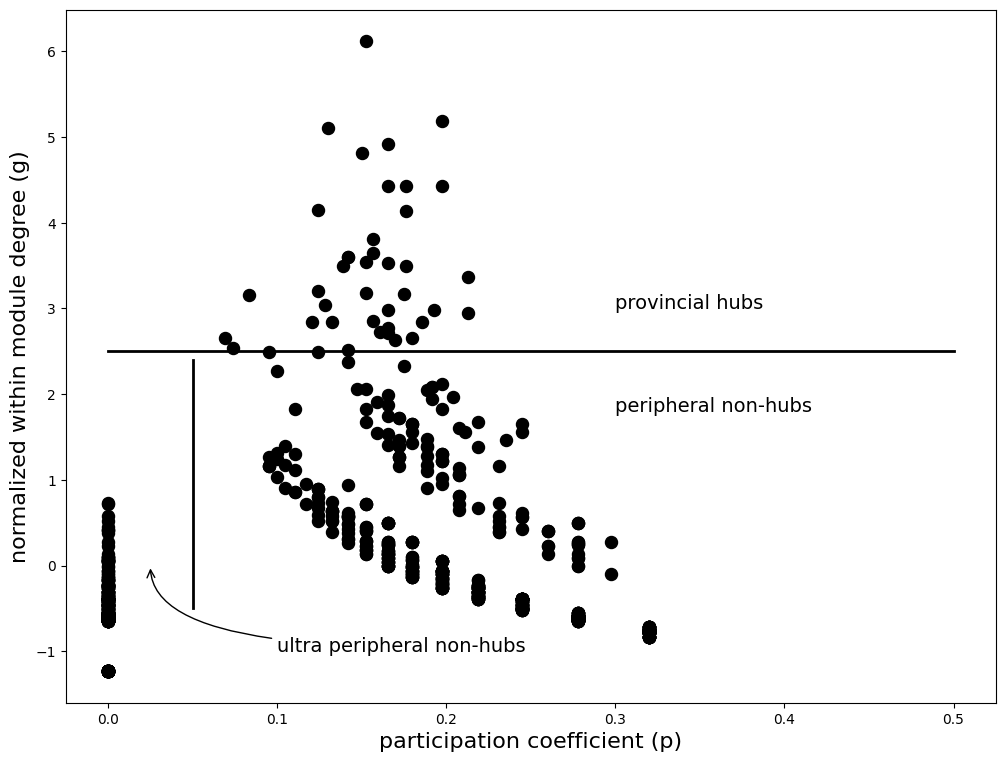

In [12]:
## Figure 5.3(b) -- comparing the roles
fig, ax = plt.subplots(figsize=(12,9))
ax.scatter(g.vs['p'],g.vs['z'],marker='o',s=75, color='k')

plt.plot([0, .5], [2.5, 2.5], color='k', linestyle='-', linewidth=2)
plt.plot([.05, .05], [-.5, 2.4], color='k', linestyle='-', linewidth=2)

ax.annotate('provincial hubs',(.3,3), fontsize=14)
ax.annotate('peripheral non-hubs',(.3,1.8), fontsize=14)
ax.annotate('ultra peripheral non-hubs',(0.025,0.0),xytext=(.1,-1), fontsize=14,
             arrowprops = dict( arrowstyle="->", connectionstyle="angle3,angleA=0,angleB=-90"))

plt.xlabel('participation coefficient (p)',fontsize=16)
plt.ylabel('normalized within module degree (g)',fontsize=16);
#plt.savefig('zachary_roles_2.eps')

# Q6 Compare time complexities of various clustering algorithms (ECG, Louvain, Infomap, Label Propagation, Girvan-Newman, CNM) using an ABCD synthetic graph 
# with different number of nodes, say, n = 100; 200; 400; 800; 1600; : : :. Which algorithm is the slowest, which one is the fastest?

In [13]:
import time
def get_runtimes(graph, run_gn=True):
    n = len(graph.vs())
    print(f"# Nodes: {n}")
    start = time.time()
    ecg = graph.community_ecg()
    elapsed = time.time() - start
    print(f"Elapsed time for ECG with n = {n}: {elapsed}")

    start = time.time()
    louvain = graph.community_multilevel()
    elapsed = time.time() - start
    print(f"Elapsed time for Louvain with n = {n}: {elapsed}")

    start = time.time()
    info_map = graph.community_infomap()
    elapsed = time.time() - start
    print(f"Elapsed time for info_map with n = {n}: {elapsed}")

    start = time.time()
    lab_prop = graph.community_label_propagation()
    elapsed = time.time() - start
    print(f"Elapsed time for lab_prop with n = {n}: {elapsed}")

    if run_gn:
        start = time.time()
        gn = graph.community_edge_betweenness()
        elapsed = time.time() - start
        print(f"Elapsed time for Girvan-Newman with n = {n}: {elapsed}")

    start = time.time()
    cnm = graph.community_fastgreedy()
    elapsed = time.time() - start
    print(f"Elapsed time for cnm with n = {n}: {elapsed}")

In [14]:
n = 100
min_degree = int(np.ceil(n/200))
max_degree = int(np.ceil(n/20))
min_community = int(np.ceil(n/10*0.75))
max_community = int(np.ceil(n/10*1.5))

abcd_100_graph = generate_abcd(n=n, gamma=2.5, tau=1.5, min_degree=min_degree, max_degree=max_degree, min_community=min_community, max_community=max_community, mixing_parameter=0.1)
get_runtimes(abcd_100_graph)

#n = 1000
#abcd_graph = generate_abcd(n=n, gamma=2.5, tau=1.5, min_degree=5, max_degree=50, min_community=75, max_community=150, mixing_parameter=0.1)

number of communities: 10
# Nodes: 100
Elapsed time for ECG with n = 100: 0.004001617431640625
Elapsed time for Louvain with n = 100: 0.0
Elapsed time for info_map with n = 100: 0.002000093460083008
Elapsed time for lab_prop with n = 100: 0.0
Elapsed time for Girvan-Newman with n = 100: 0.0010001659393310547
Elapsed time for cnm with n = 100: 0.0


In [15]:
n = 200
min_degree = int(np.ceil(n/200))
max_degree = int(np.ceil(n/20))
min_community = int(np.ceil(n/10*0.75))
max_community = int(np.ceil(n/10*1.5))

abcd_200_graph = generate_abcd(n=n, gamma=2.5, tau=1.5, min_degree=min_degree, max_degree=max_degree, min_community=min_community, max_community=max_community, mixing_parameter=0.1)
get_runtimes(abcd_200_graph)

number of communities: 10
# Nodes: 200
Elapsed time for ECG with n = 200: 0.0070018768310546875
Elapsed time for Louvain with n = 200: 0.0009999275207519531
Elapsed time for info_map with n = 200: 0.01100301742553711
Elapsed time for lab_prop with n = 200: 0.0010001659393310547
Elapsed time for Girvan-Newman with n = 200: 0.004000663757324219
Elapsed time for cnm with n = 200: 0.0


In [16]:
n = 400
min_degree = int(np.ceil(n/200))
max_degree = int(np.ceil(n/20))
min_community = int(np.ceil(n/10*0.75))
max_community = int(np.ceil(n/10*1.5))

abcd_400_graph = generate_abcd(n=n, gamma=2.5, tau=1.5, min_degree=min_degree, max_degree=max_degree, min_community=min_community, max_community=max_community, mixing_parameter=0.1)
get_runtimes(abcd_400_graph)

number of communities: 9
# Nodes: 400
Elapsed time for ECG with n = 400: 0.028007030487060547
Elapsed time for Louvain with n = 400: 0.0009996891021728516
Elapsed time for info_map with n = 400: 0.08501911163330078
Elapsed time for lab_prop with n = 400: 0.0010004043579101562
Elapsed time for Girvan-Newman with n = 400: 0.3870866298675537
Elapsed time for cnm with n = 400: 0.0010008811950683594


In [17]:
n = 800
min_degree = int(np.ceil(n/200))
max_degree = int(np.ceil(n/20))
min_community = int(np.ceil(n/10*0.75))
max_community = int(np.ceil(n/10*1.5))

abcd_800_graph = generate_abcd(n=n, gamma=2.5, tau=1.5, min_degree=min_degree, max_degree=max_degree, min_community=min_community, max_community=max_community, mixing_parameter=0.1)
get_runtimes(abcd_800_graph)

number of communities: 11
# Nodes: 800
Elapsed time for ECG with n = 800: 0.09502148628234863
Elapsed time for Louvain with n = 800: 0.0030007362365722656
Elapsed time for info_map with n = 800: 0.13102936744689941
Elapsed time for lab_prop with n = 800: 0.002000570297241211
Elapsed time for Girvan-Newman with n = 800: 16.565280437469482
Elapsed time for cnm with n = 800: 0.006001710891723633


In [18]:
n = 1600
min_degree = int(np.ceil(n/200))
max_degree = int(np.ceil(n/20))
min_community = int(np.ceil(n/10*0.75))
max_community = int(np.ceil(n/10*1.5))

abcd_1600_graph = generate_abcd(n=n, gamma=2.5, tau=1.5, min_degree=min_degree, max_degree=max_degree, min_community=min_community, max_community=max_community, mixing_parameter=0.1)
get_runtimes(abcd_1600_graph, run_gn=False) #Girvan Newman is very time consuming so we run it separately

number of communities: 10
# Nodes: 1600
Elapsed time for ECG with n = 1600: 0.3160703182220459
Elapsed time for Louvain with n = 1600: 0.007001399993896484
Elapsed time for info_map with n = 1600: 0.13503050804138184
Elapsed time for lab_prop with n = 1600: 0.002000093460083008
Elapsed time for cnm with n = 1600: 0.047010183334350586


In [ ]:
# To see GN runtime for n=1600, run this command. On my system it ran for over an hour then crashed
start = time.time()
cnm = abcd_1600_graph.community_edge_betweenness()
elapsed = time.time() - start
print(f"Elapsed time for cnm with n = {1600}: {elapsed}")

Q6 Answer: From the runs of our algorithms, label propagation is generally the fastest. This is expected, as label propagation is known as a fast algorithm, even if it is not necessarily the best one. In terms of the slowest algorithm, ECG is the slowest for n <= 400, while Girvan-Newman is the slowest for n>400